In [1]:
import pandas as pd
import re

import gensim

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer

import warnings 
warnings.filterwarnings(action='ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss

train = pd.read_csv('/content/drive/MyDrive/archive (2)/open/train.csv')
sample = pd.read_csv('/content/drive/MyDrive/archive (2)/open/sample_submission.csv')
test = pd.read_csv('/content/drive/MyDrive/archive (2)/open/test_x.csv')

In [2]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

train['text']=train['text'].apply(alpha_num)



In [3]:
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]



In [4]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)


In [5]:
# train test 분리
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

In [6]:
tmp = train
for i in range(len(tmp['text'])):
    tmp['text'][i] = tmp['text'][i].strip().split()

vocab = nltk.FreqDist(np.hstack(tmp['text']))
print('단어 집합의 크기 : {}'.format(len(vocab)))

단어 집합의 크기 : 47136


In [7]:
vocab_size = len(vocab)
vocab = vocab.most_common(vocab_size)

print('단어 집합의 크기 : {}'.format(len(vocab)))

단어 집합의 크기 : 47136


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
word_to_index = {word[0] : index + 2 for index, word in enumerate(vocab)}
word_to_index['unk'] = 0

In [10]:
encoded = []
for line in train['text']: #입력 데이터에서 1줄씩 문장을 읽음
    temp = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
        try:
            temp.append(word_to_index[w]) # 글자를 해당되는 정수로 변환
        except KeyError: # 단어 집합에 없는 단어일 경우 unk로 대체된다.
            temp.append(word_to_index['unk']) # unk의 인덱스로 변환
    encoded.append(temp)

In [11]:
vocab_size = 47120
embedding_dim = 16
max_length = 212
padding_type = 'post'

In [12]:
#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [13]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)

# train_sequences
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

# train_padded
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [14]:
embedding_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/archive (2)/open/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [15]:
embedding_matrix = np.zeros((vocab_size, 300))
def get_vector(word):
    if word in embedding_model:
        return embedding_model[word]
    else:
        return None

vocab = nltk.FreqDist(np.hstack(train['text']))

In [16]:
for idx,word in enumerate(vocab.items()):
    print(word[0])
    temp = get_vector(word[0])
    
    if temp is not None: 
        embedding_matrix[idx] = temp

print(embedding_matrix.shape)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
fivescore
zarasky
begot
humanechristian
factwe
crucible
trainingstable
ahnohave
fads
100
spurn
rarest
sweetened
spluttered
fie
downy
betted
handkercher
handkerchersand
ladieswhat
wellintentioned
cherlie
explainedand
hanle
saidfirst
sickerly
tiffin
enigmas
ungallant
sentimentally
recited
cheerfuller
notis
martinhe
indeedquite
ofbut
optical
themby
whowhos
antonitchs
resides
cairn
chappin
eicht
knockdow
mlellan
linkin
kilmackerlie
sinsyne
fashed
inhale
forwhat
simpletons
objectwhat
collapses
noteswhat
thousandhe
fin
conceding
alefor
dereliction
timesthree
worthyou
archimandrite
reviewer
hoodwinking
kaleleaf
shadowing
freemasonry
heroworship
oiling
linkbearers
winebut
rarityand
upwood
nonpareil
montpensier
melodramas
streaky
regales
vassals
vaults
carolling
feelingperhaps
towing
fogdraped
historythe
cavedwellers
conqueststhe
victories
gospels
humblest
despondently
bleakest
futility
outwearied
misjudge
moser
trajan
destroyers
reactionaries
castigate
poiso

IndexError: ignored

In [17]:
for index, word in enumerate(vocab.items()):

    
  if word in embedding_model:
    embedding_vector = embedding_model[word]
    embedding_matrix[index] = embedding_vector

In [18]:
embedding_matrix

array([[ 0.18652344, -0.14941406,  0.05883789, ...,  0.05957031,
         0.06884766,  0.04516602],
       [ 0.22753906,  0.078125  ,  0.22265625, ...,  0.140625  ,
        -0.13183594, -0.00872803],
       [ 0.16894531,  0.06396484, -0.08447266, ..., -0.171875  ,
        -0.02929688, -0.20605469],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [19]:
vocab_size = 50000 
embedding_dim = 200  
max_length = 150    
padding_type='post'

In [23]:
# Simple RNN 레이어를 사용한 모델 (model1) 정의
model1 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 64),
        Dense(5, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model1.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 200)          10000000  
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 150, 64)           16960     
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 150, 64)           8256      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 10,033,797
Trainable params: 10,033,797
Non-trainable params: 0
_________________________________________________________________


In [40]:
 history = model1.fit(X_train, y_train, epochs=10, batch_size=100, validation_split= 0.2) 
 #model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])??



Epoch 1/10


ValueError: ignored

In [37]:
history = model1.fit(train_x, train_y, epochs=10, batch_size=100, validation_split= 0.2) 

None


AttributeError: ignored

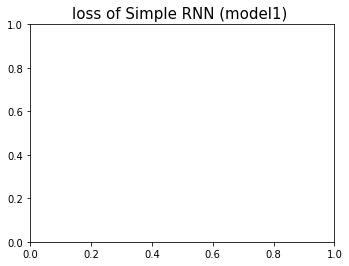

In [29]:
plt.figure(figsize=(12, 4))
plt.title('Simple RNN (model1) ', fontsize= 15)

plt.subplot(1, 2, 1)
plt.title('loss of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [32]:
print(f'Accuracy : {accuracy_score(y_train, np.argmax(validation, axis=1)) * 100:8.4f}%')
print(f'Log Loss : {log_loss(pd.get_dummies(y_train), validation):8.4f}')

NameError: ignored